# Luca Miglior - Assignment 2 - Track 3


## Introduction
For this assignment purposes, i have implemented a simple Restricted boltzmann machine model.
The training algorithm is mainly based on on-line contrastive divergence learning. In particular, CD-1 learning has been implemented, meaning that only one step of the more general CD-K algorithm will be computed, for each sample, to estimate the gradient of the log likelihood w.r.t. to model's weights.

As presented during the course, CD-1 gradient estimation implementation is based on the following equation: 
$$ \frac{\partial \mathcal{L}}{\partial{M_{ij}}} = \langle v_ih_j \rangle_0 - \langle v_ih_j \rangle_1 = wake - dream $$
where the first term of the second member has been named the `wake` part of the gradient, because it is computed on the actual data and the second term is the `dream` part, based on the reconstruction. The training algorithm follows the schema presented by Hinton's in [2]. Main algorithm's steps are the following:

1. Randomly initialize weights and biases for the model.
2. Then, for `epochs` epochs, for `data in dataset`
3. Compute $P(h|v) = \sigma(Mv + b_h)$
4. Compute $wake = P(h|v)v $
5. Now, sample the binary hidden states based on $P(h|v)$
6. Compute probabilities of the reconstruction as $P(v = 1|h) = \sigma(Mh + b_v)$ and sample reconstructed states on them
7. Get again the probability distribution of the hidden states given the reconstruction and compute the dream part
8. compute $\Delta w = wake - dream$ and biases
9. finally update model's parameters according to a user-defined parameter `learning_rate`
 
Full code can be found in the file `rbm.py` with further details.

## First part, import dataset and preparing it by binarizing data.

In [1]:
from rbm import RestrictedBoltzmannMachine as RBM
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import mnist


# load the dataset
# https://keras.io/api/datasets/mnist/ (same provided on e-learning)

dataset = mnist.load_data()
X_train, y_train = dataset[0]
X_test, y_test = dataset[1]

# binarize the dataset

X_train_bin = (X_train > 0).astype(int)
X_test_bin = (X_test > 0).astype(int)

# flatten the dataset
X_train = X_train.reshape(X_train.shape[0], -1)/255
X_train_bin = X_train_bin.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)/255
X_test_bin = X_test_bin.reshape(X_test.shape[0], -1)

2023-04-11 18:05:15.034561: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Some words on reconstruction metrics
We have to compute some metrics, in order to assess our model's performance. For this task, i decided to exploit the basic accuracy and recall definitions, as well as the structural similarity metrics. In particular, structural similarity is well defined in [1].

Standard accuracy may not be the most suitable metric for this problem: in fact, given an image and its reconstruction, this would be a really imbalanced classification task, and I expect to find decent accuracy values even for poor reconstructions, since the vast majority of the pixels are black (negative class). For this reason, a custom accuracy will be computed among all the positive-matching pixels in the image.

I will also define another metric, representing the mean error on pixel, defined as follows:
$$MEP = \frac{1}{i \times j}\sum_{i}\sum_{j} |y^{t}_{ij} - y^{p}_{ij}|$$

This metric can assume values in [0,1] for [0,1] normalized images. The closest to zero, the better the reconstruction

The following cell defines a method that given an instance of my brand new RBM class will reuturn a triple with these metrics, averaged on all the samples in the provided test set. 



Metrics implementation was taken from `sklearn` and `skimage` libraries.

In [11]:
from sklearn.metrics import accuracy_score, recall_score, classification_report
from skimage.metrics import structural_similarity

def positive_accuracy(y_true, y_pred):
    positive = y_true[y_true == 1]
    positive_pred = y_pred[y_true == 1]
    return accuracy_score(positive, positive_pred)

def mep(y_true, y_pred):
    # same as during training, take the mean of the difference 
    return np.mean(np.abs(y_true - y_pred))
    

def evaluate_rbm(rbm, X_test):
    """
    Evaluate performance of the given RBM.
    :param rbm: an instance of RestrictedBoltzmannMachine class
    :X_test: test data
    :return: triple <model accuracy, model recall, model structural similarity>
    """
    accuracy = []
    pa= []
    ssims = []
    mse = []

    for i in range(len(X_test)):
        test_sample = X_test[i]
        reconstructed = rbm.reconstruct(test_sample, sample=False)
     
        # sampling reconstructions
        reconstructed = reconstructed > np.random.rand(len(reconstructed))
        reconstructed = reconstructed.astype('int64')
        # computing metrics
        accuracy.append(accuracy_score(test_sample, reconstructed))
        pa.append(positive_accuracy(test_sample, reconstructed))
        mse.append(mep(test_sample, reconstructed))
        ssims.append(structural_similarity(test_sample, reconstructed, data_range=1))
        
    
        
    return np.mean(accuracy), np.mean(pa), np.mean(ssims), np.mean(mse)

## Experiments 

In this section some relevant results will be reported. As requested, for the first tests, there will be one RBM for each digit.

### Let's see what happens during the training of a RBM, let's say, on digit 5.
The following cell will show the training error expressed as MSE and will show model's weights as libraris, to explore what's happening behind the scenes.

This digit was chosen among the others because of it's "complex shape".

Let's start with a model with 64 hidden states. Epoch number is set to 25.

In [17]:
rbm = RBM(784, 64)
rbm.train(X_train_bin[y_train == 5], epochs=25, learning_rate=0.1)

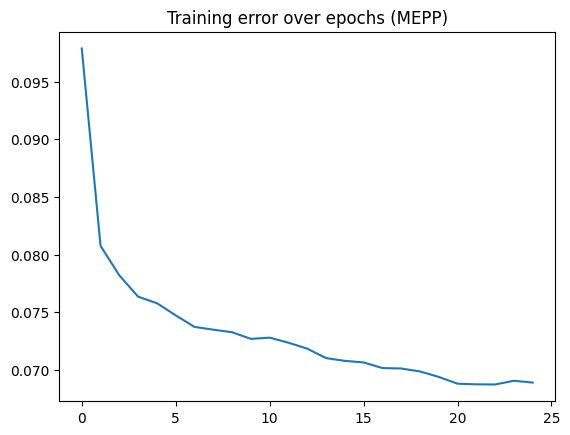

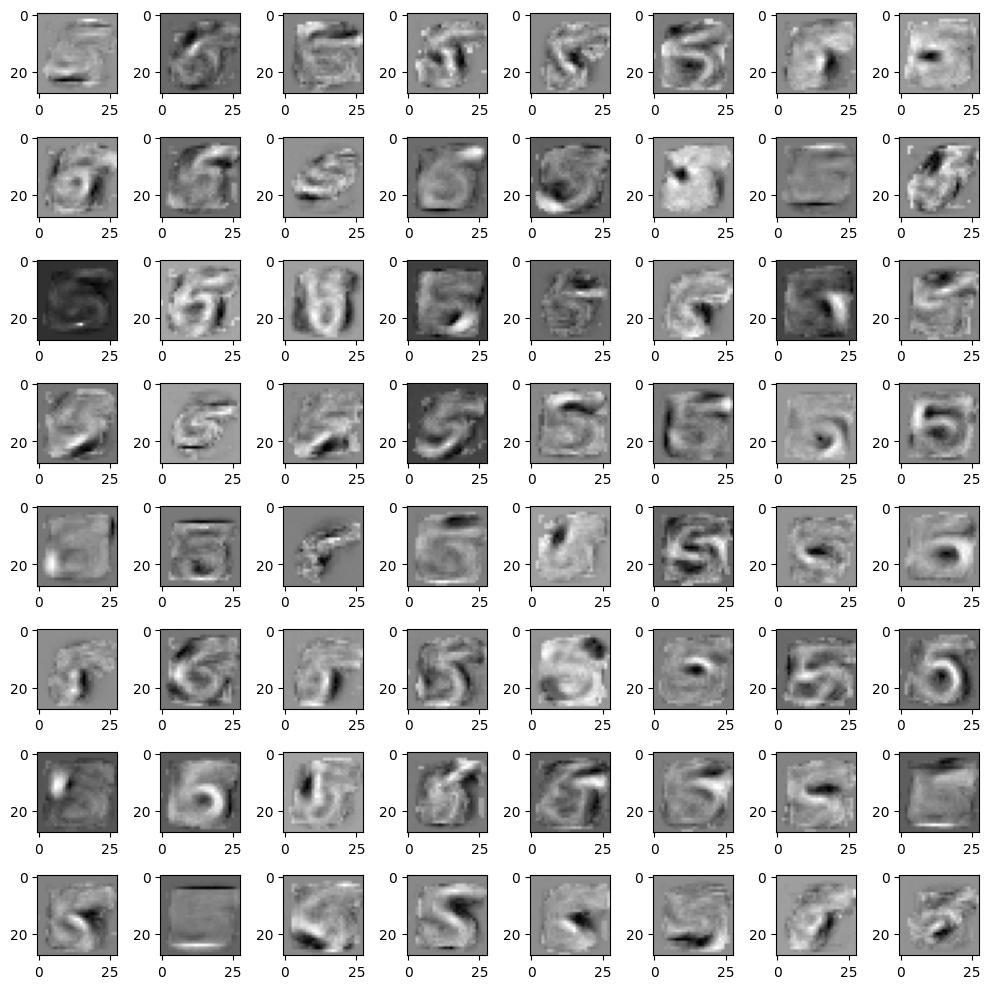

In [21]:
plt.plot(rbm.errors)
plt.title("Training error over epochs (MEPP)")

# plotting the 64 weights
fig, axes = plt.subplots(8, 8, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    # reshaping the weights vector for each unit to the original 28x28 image shape
    ax.imshow(rbm.weights[i].reshape(28, 28), cmap='gray')

fig.tight_layout()

After the first iterations, TR error suddently dropped, and learning curve behaves as expected. Moreover, we can see that model's weights have been modified by the CD algorithm to match the shape of our digit.
Plotting model's weights after training phase is kinda funny though.

In [22]:
# evaluate the rbm
acc, rec, ssim, pe = evaluate_rbm(rbm, X_test_bin[y_test == 5])
print(f"Accuracy: {acc:.2f}, Positive accuracy {rec:.2f}, Structural similarity: {ssim:.2f}, MEP: {pe:.2f} ")


Accuracy: 0.93, Positive accuracy 0.82, Structural similarity: 0.78, MEP: 0.07 


The above computed metrics shows that the algorithm is actually learning. In particular, structular similarity and MEP are respectively quite high and low respectively for the images in the binary test set.

### Showing reconstruction and metrics for random selected test images

ssim: 0.822339
MEP: 0.048425


Text(0.5, 1.0, 'Reconstructed')

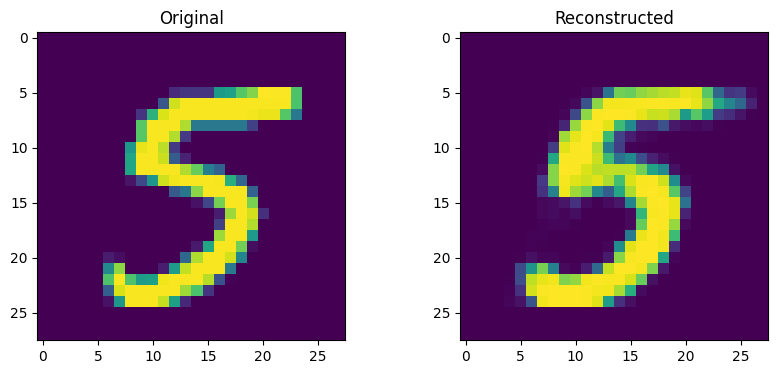

In [41]:
# print the original image and the reconstructed one
test_sample = X_test[y_test == 5][np.random.randint(0, X_test[y_test == 5].shape[0])]
reconstructed = rbm.reconstruct(test_sample, sample=False)

ssim = structural_similarity(reconstructed, test_sample, data_range=1)
print(f'ssim: {ssim:2f}')

pixel_err= mep(reconstructed, test_sample)
print(f'MEP: {pixel_err:2f}')

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(test_sample.reshape(28, 28))
axes[1].imshow(reconstructed.reshape(28, 28))
# add labels 
axes[0].set_title('Original')
axes[1].set_title('Reconstructed')

### Try to improve model performances by tuning the number of units and epochs.

#### 32 units, 25 epochs

In [42]:
rbm = RBM(784, 32)
rbm.train(X_train_bin[y_train == 5], epochs=25, learning_rate=0.1)

# evaluate the rbm
acc, rec, ssim, pe = evaluate_rbm(rbm, X_test_bin[y_test == 5])
print(f"> Accuracy: {acc:.2f}, Positive accuracy {rec:.2f}, Structural similarity: {ssim:.2f}, MEP: {pe:.2f} ")

> Accuracy: 0.90, Positive accuracy 0.75, Structural similarity: 0.72, MEP: 0.10 


32 units are definetly not enough.

#### 64 units, 50 epochs

In [43]:
rbm = RBM(784, 64)
rbm.train(X_train_bin[y_train == 5], epochs=50, learning_rate=0.1)

# evaluate the rbm
acc, rec, ssim, pe = evaluate_rbm(rbm, X_test_bin[y_test == 5])
print(f"> Accuracy: {acc:.2f}, Positive accuracy {rec:.2f}, Structural similarity: {ssim:.2f}, MEP: {pe:.2f} ")

> Accuracy: 0.93, Positive accuracy 0.83, Structural similarity: 0.79, MEP: 0.07 


Increasing the number of epochs does not improve reconstruction quality

#### 128 units, 25 epochs

In [44]:
rbm = RBM(784, 128)
rbm.train(X_train_bin[y_train == 5], epochs=25, learning_rate=0.1)

# evaluate the rbm
acc, rec, ssim, pe = evaluate_rbm(rbm, X_test_bin[y_test == 5])
print(f"> Accuracy: {acc:.2f}, Positive accuracy {rec:.2f}, Structural similarity: {ssim:.2f}, MEP: {pe:.2f} ")

> Accuracy: 0.94, Positive accuracy 0.86, Structural similarity: 0.82, MEP: 0.06 


Slightly better. Try doubling again the units.

#### 256 units, 25 epochs

In [45]:
rbm = RBM(784, 256)
rbm.train(X_train_bin[y_train == 5], epochs=25, learning_rate=0.1)

# evaluate the rbm
acc, rec, ssim, pe = evaluate_rbm(rbm, X_test_bin[y_test == 5])
print(f"> Accuracy: {acc:.2f}, Positive accuracy {rec:.2f}, Structural similarity: {ssim:.2f}, MEP: {pe:.2f} ")

> Accuracy: 0.95, Positive accuracy 0.87, Structural similarity: 0.84, MEP: 0.05 


Again better. I will try to increase a little bit the epochs to crank up model performances

#### 256 units, 30 epochs

In [46]:
rbm = RBM(784, 256)
rbm.train(X_train_bin[y_train == 5], epochs=30, learning_rate=0.1)

# evaluate the rbm
acc, rec, ssim, pe = evaluate_rbm(rbm, X_test_bin[y_test == 5])
print(f"> Accuracy: {acc:.2f}, Positive accuracy {rec:.2f}, Structural similarity: {ssim:.2f}, MEP: {pe:.2f} ")

> Accuracy: 0.95, Positive accuracy 0.87, Structural similarity: 0.83, MEP: 0.05 


No improvements with this tuning. I will go for 256-30 configuration.

### Let's now dig into the assessed model for fives.

In the following sections, I will try to reconstruct some correct five images, as well as wrong ones (e.g. by feeding a "8" instead of "5".)


I will also show the metrics for each reconstruction.
> **Note:** These tests will only be run on the 5-labelled images of the MNIST dataset, for ease of presentation. Comparable results have been obtained on all the classes found in the dataset.

In [47]:
rbm = RBM(784, 256)
rbm.train(X_train_bin[y_train == 5], epochs=25, learning_rate=0.1)

# evaluate the rbm
acc, rec, ssim, pe = evaluate_rbm(rbm, X_test_bin[y_test == 5])
print(f"> Accuracy: {acc:.2f}, Positive accuracy {rec:.2f}, Structural similarity: {ssim:.2f}, MEP: {pe:.2f} ")

> Accuracy: 0.95, Positive accuracy 0.87, Structural similarity: 0.84, MEP: 0.05 


#### Reconstruct other images of fives with the "fine tuned" model.

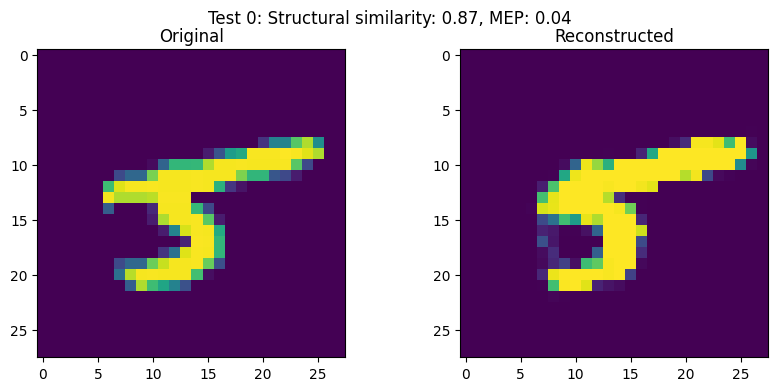

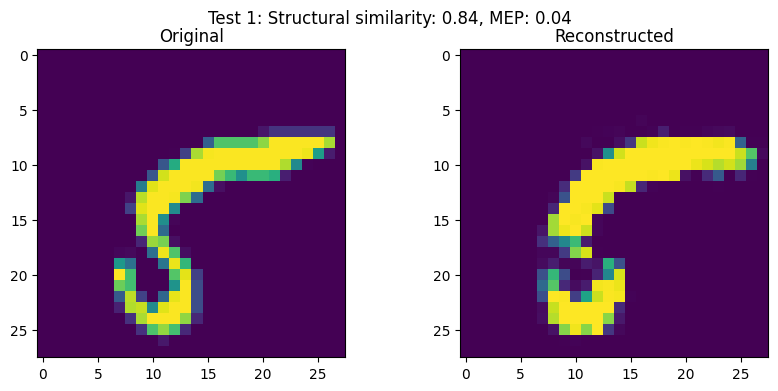

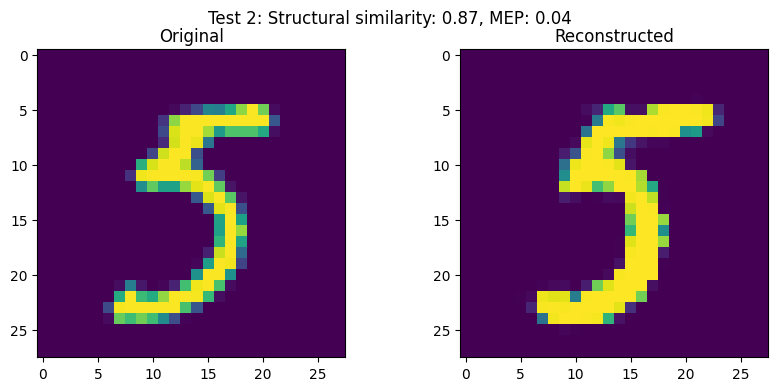

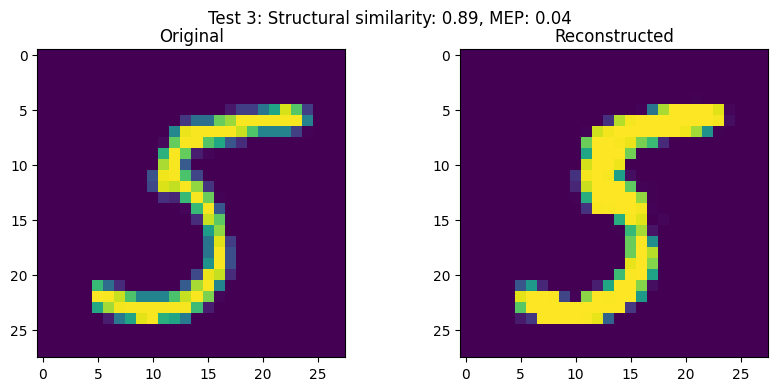

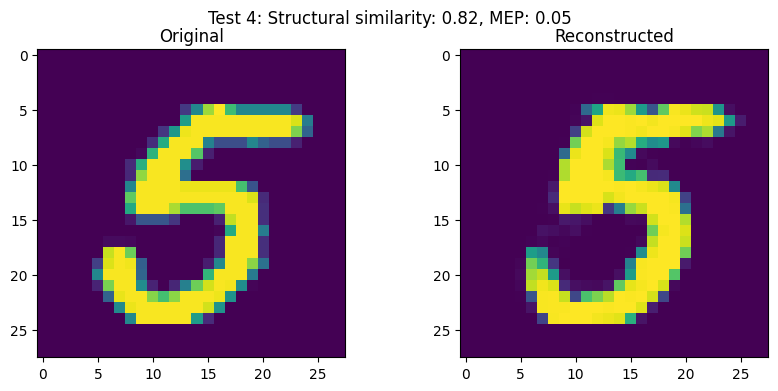

In [49]:
# print the original image and the reconstructed one
for x in range(5):
    test_sample = X_test[y_test == 5][np.random.randint(0, X_test[y_test == 5].shape[0])]
    reconstructed = rbm.reconstruct(test_sample, sample=False)

    ssim = structural_similarity(reconstructed, test_sample, data_range=1)
    pe= mep(reconstructed, test_sample)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(test_sample.reshape(28, 28))
    axes[1].imshow(reconstructed.reshape(28, 28))
    # add labels 
    fig.suptitle(f"Test {x}: Structural similarity: {ssim:.2f}, MEP: {pe:.2f}")
    axes[0].set_title('Original')
    axes[1].set_title('Reconstructed')

#### Result with correct images are quite satisfying.
The considered metrics are good. In particular, Structural similarity is always above 0.8 which is a good result. Moreover, as human, i can definitely tell that reconstructions are OK.


### RBM as denoiser
Can my RBM trained on clean images act as a denoiser?
I will add some noise to the images in the test set first, then submit a selection of images to the model.

Text(0.5, 0.98, 'Eight images with gaussian noise added.')

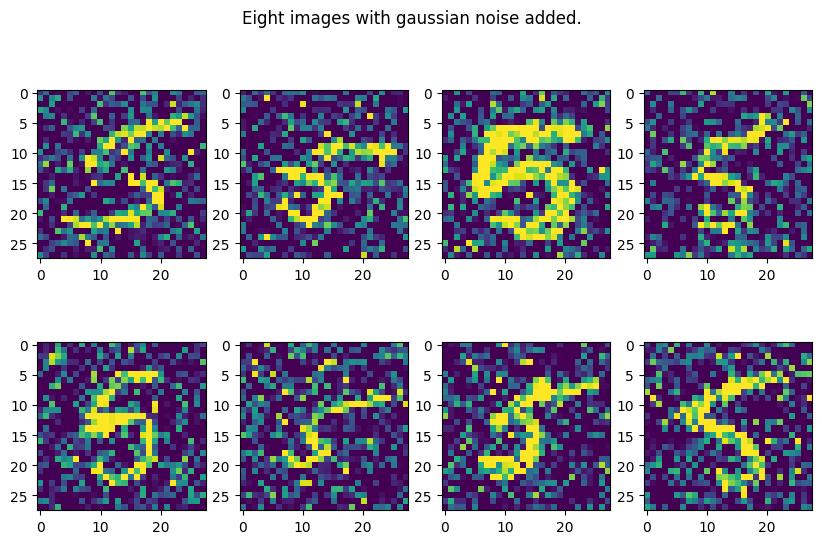

In [61]:
noise = 0.4
X_test_noise = X_test + noise * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)
X_test_noise = np.clip(X_test_noise, 0., 1.)

fig, axs = plt.subplots(2, 4, figsize=(10, 6))

for ax in axs.flatten():
    # reshaping the weights vector for each unit to the original 28x28 image shape
    ax.imshow(X_test_noise[y_test==5][np.random.randint(0, X_test[y_test == 5].shape[0])].reshape(28, 28))

fig.suptitle("Eight images with gaussian noise added.")

Text(0.5, 0.98, 'Denoised images with trained RBM.')

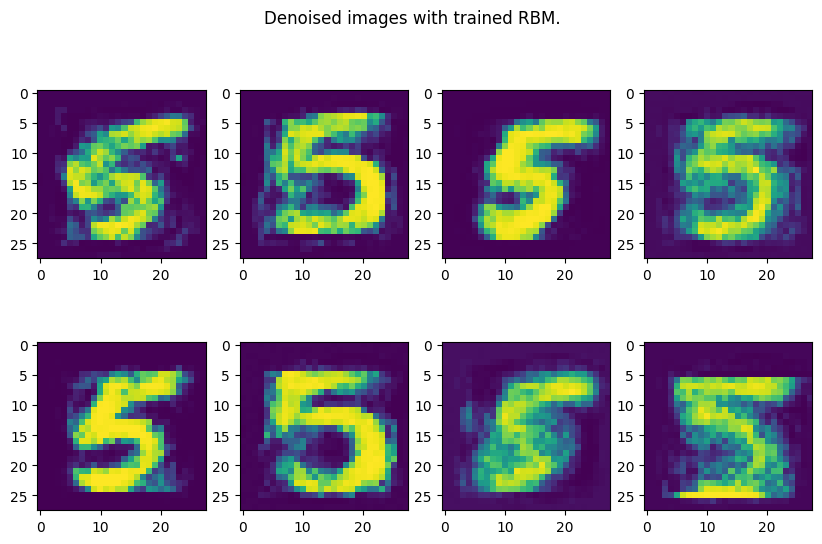

In [62]:
# trying to denoise
fig, axs = plt.subplots(2, 4, figsize=(10, 6))

for i, ax in enumerate(axs.flatten()):
    # reshaping the weights vector for each unit to the original 28x28 image shape
    ax.imshow(rbm.reconstruct(X_test_noise[y_test==5][i], sample=False).reshape(28, 28))

fig.suptitle("Denoised images with trained RBM.")

Again, from a human point of view i can tell that images have been denoised pretty well, considering the totally unsupervised approach. It seems that the model tries to reconstruct a more general "5" based on the images provided. Images with too much noise give poor reconstruction results.

### The final experiment: try a single RBM on all the digits.
256 units, 25 epochs.
> **This cell may take a while to run**

In [63]:
# train one rbm for each digit in the train set
rbm = RBM(784, 256)
rbm.train(X_train_bin, epochs=25, learning_rate=0.1)

# evaluate the rbm
acc, rec, ssim, pe = evaluate_rbm(rbm, X_test_bin)
print(f"> Accuracy: {acc:.2f}, Positive accuracy {rec:.2f}, Structural similarity: {ssim:.2f}, MEP: {pe:.2f} ")


## References
Course slides

[[1] Wang et al., Image Quality Assessment: From Error Visibility to Structural Similarity](http://www.cns.nyu.edu/pub/eero/wang03-reprint.pdf)

[[2] G. Hinton, A Practical Guide to Training Restricted Boltzmann Machines](https://www.cs.toronto.edu/~hinton/absps/guideTR.pdf)

[[3] A. Fischer et al., Training restricted Boltzmann machines: An introduction](https://www.sciencedirect.com/science/article/abs/pii/S0031320313002495)

